# Ocean color

This notebook explores using Satellogic hyperspectral camera for data over the Oceans. [Hyperspectral measurements over water bodies](https://en.wikipedia.org/wiki/Ocean_color) can be used to infer important information such as phytoplankton biomass or concentrations of other living and non-living material that modify the characteristics of the incoming radiation.




In [4]:
coasts={
    'gambia': '257e8052c6d94b72ada0b788173791fa',
    'new_caledonia':'8b87092b8ab84274b6cfffe692ec7f48',
    'brisbaine':'a7f72dce16144bd081638245ab5bc9e6',
    'nomad_reef_australia':'e3986d344eaa4d50b774c481c3c92349',
    'east_arnhem_australia': '269cf5066c454d21b33eb8a1a1dc9427',
    'francois_peron_australia': 'cfe34cf8e8b9484d9f223ba81c09ff89',
    'busan_south_korea': 'c43161af2a8043beab9da9983b58628a',
    'incheon_south_korea': 'ecc30e5283b94ecb9dcf439d3073d0f2',
    'gulf_of_khambhat': '326b5da660454cdbb838e9f8823fc209',
    'shandong_china': '3a268c62be314b67a4a0a00b1a629f79',
    'bahrain': '5996f4d56abf47ca99790a1586c00a09',
    'louisiana': '701d276bcc7f4dc29bd9571041314a5b'}

# How to get the Satellogic hypersectral data

See [Documentation on how to download Data](https://github.com/satellogic/open-impact/blob/master/Accessing-data.md) either via web or API.

Getting token...
JWT eyJ0eX*masked*
'gambia':'newsat3_macro_cube_257e8052c6d94b72ada0b788173791fa_0_4_3'


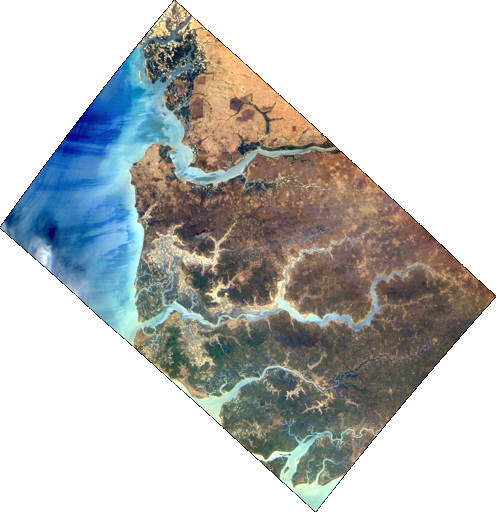

'new_caledonia':'newsat3_macro_cube_8b87092b8ab84274b6cfffe692ec7f48_0_4_0'


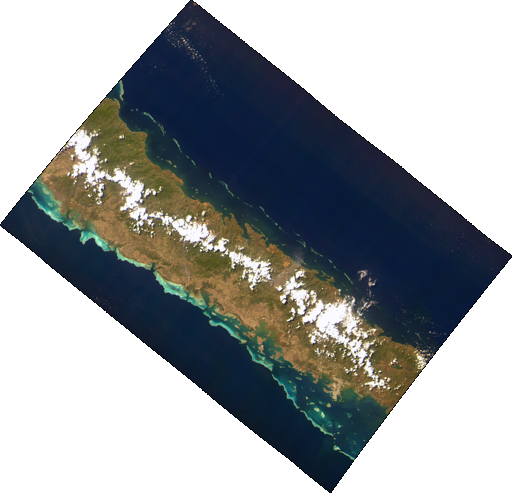

'brisbaine':'newsat3_macro_cube_a7f72dce16144bd081638245ab5bc9e6_0_4_0'


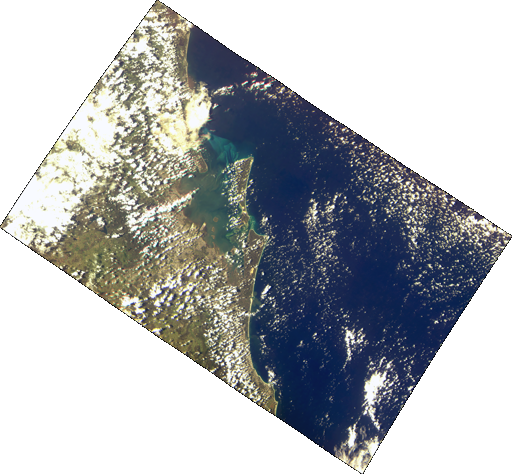

'nomad_reef_australia':'newsat3_macro_cube_e3986d344eaa4d50b774c481c3c92349_0_4_0'


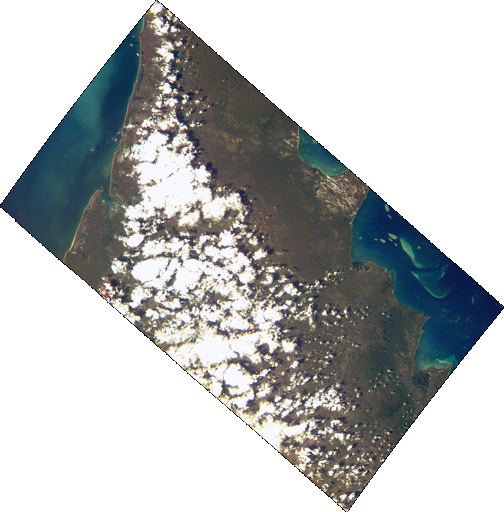

'east_arnhem_australia':'newsat3_macro_cube_269cf5066c454d21b33eb8a1a1dc9427_0_4_0'


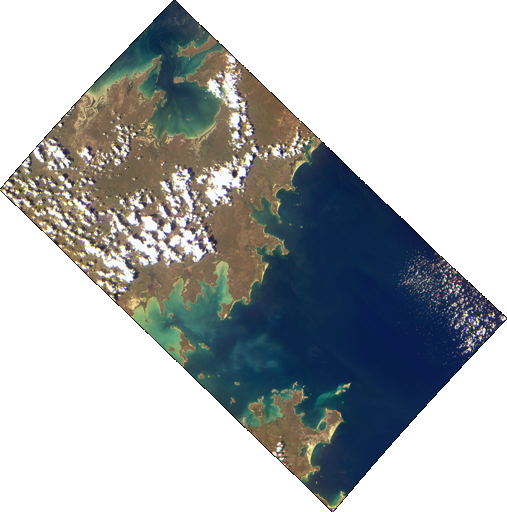

'francois_peron_australia':'newsat3_macro_cube_cfe34cf8e8b9484d9f223ba81c09ff89_0_4_0'


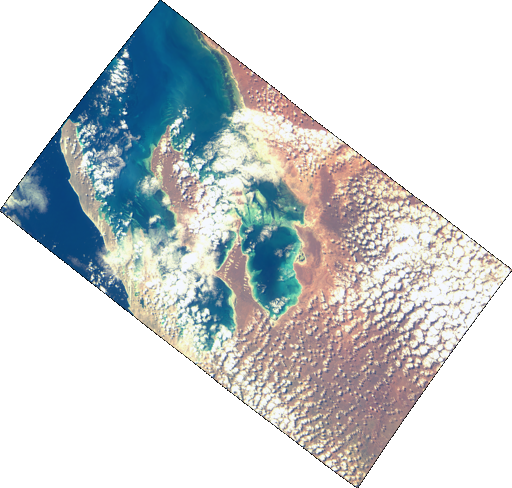

'busan_south_korea':'newsat3_macro_cube_c43161af2a8043beab9da9983b58628a_0_4_6'


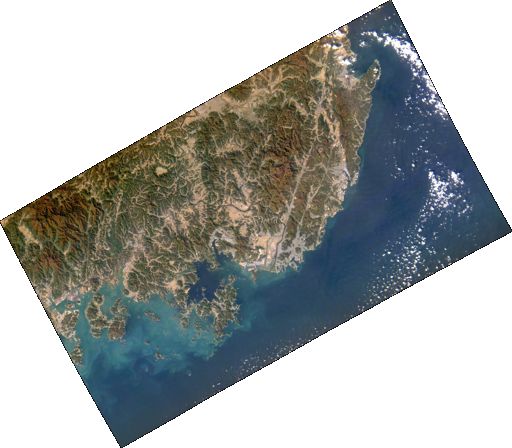

'incheon_south_korea':'newsat3_macro_cube_ecc30e5283b94ecb9dcf439d3073d0f2_0_5_2'


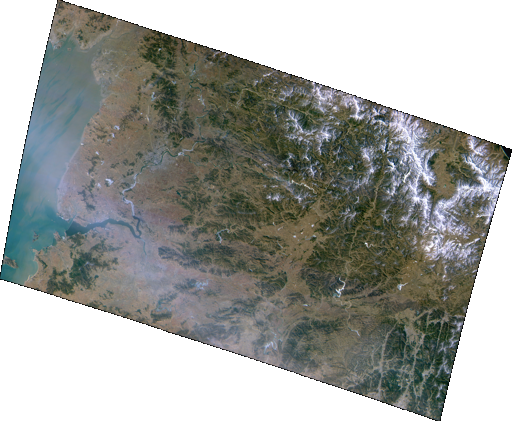

'gulf_of_khambhat':'newsat3_macro_cube_326b5da660454cdbb838e9f8823fc209_0_3_47'


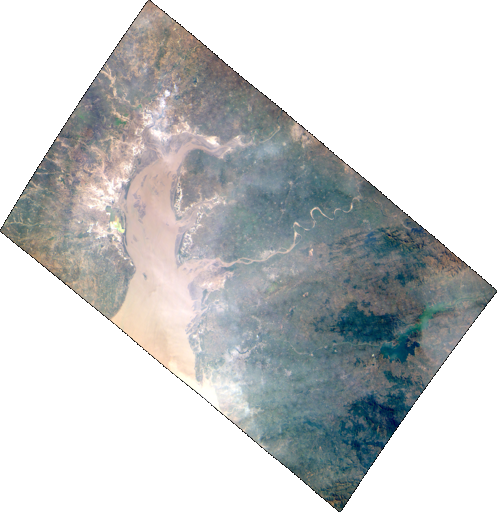

'shandong_china':'newsat3_macro_cube_3a268c62be314b67a4a0a00b1a629f79_0_3_48'


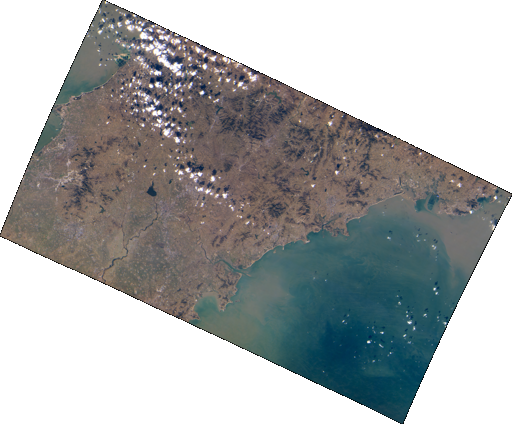

'bahrain':'newsat3_macro_cube_5996f4d56abf47ca99790a1586c00a09_0_3_48'


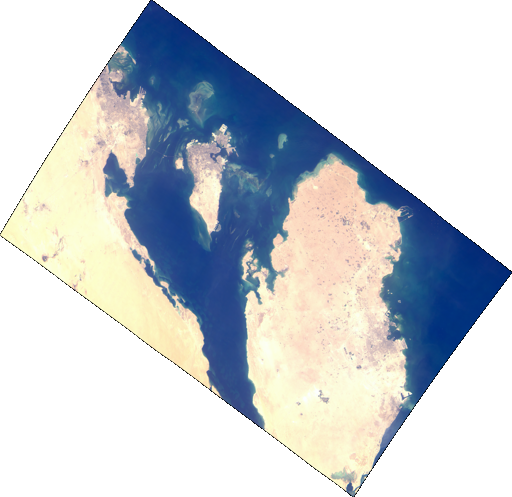

'louisiana':'newsat3_macro_cube_701d276bcc7f4dc29bd9571041314a5b_0_4_6'


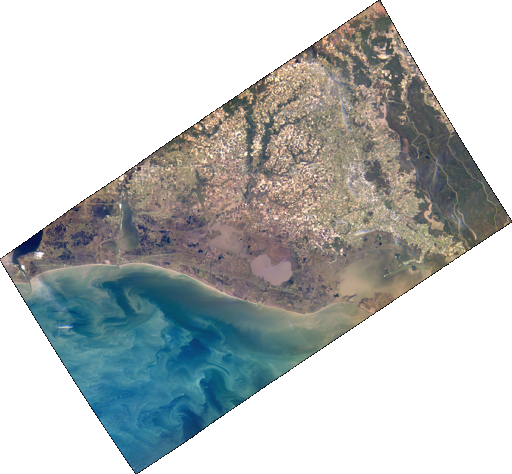

In [9]:
from IPython.display import Image
# Get thumnails of all
# Documentation https://integration.telluric.satellogic.com/docs/

import requests
url = 'https://auth.telluric.satellogic.com/api-token-auth/'
payload = {'username': 'stanfordhackathon', 'password': 'hack2018'}

print("Getting token...")
r = requests.post(url, data=payload)
if r.status_code != 200:
    raise ValueError("Telluric response error: %s" % r.text)
telluric_token = "JWT "+r.json()['token']
print(telluric_token[0:10]+"*masked*")
header = {'authorization': telluric_token}

for sid in coasts.keys():
    set_id=coasts[sid]
    url = 'https://telluric.satellogic.com/v2/scenes'
    payload = {'productname':'cube',
               'sceneset_id':set_id}
    r = requests.get(url, params=payload,headers=header)
    if r.status_code != 200:
        raise ValueError("Telluric response error: %s" % r.text)
    response = r.json()
    scene_id=response['results'][0]['scene_id']
    print("'%s':'%s'"%(sid,scene_id))
    for a in response['results'][0]['attachments']:
        if a['name']=='preview':
            display(Image(url=a['url'],width=400,format='png',embed=True))

## Download scene using zipped orders

Use this method to request a zipped file with all the rasters. Takes a while to wait for the rasters to be compressed, but it reduces download bandwidth. 

In [ ]:
# get download id for the whole raster
url = 'https://telluric.satellogic.com/v2/scenes/download/'
scene_id = 'newsat3_macro_cube_257e8052c6d94b72ada0b788173791fa_0_4_3'
# Read ALL bands,
# mask them into the ROI and
# save them into a single multiband cube
# MINIMIZE MEMORY FOOTPRINT

import fiona
import rasterio
from rasterio.mask import mask

# to mask the region we need both images in the same CRS
with fiona.open("Gambia Coast.geojson", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

header = {'authorization': telluric_token}
data = {'scene_id': scene_id,
        'async': 1}  # Important! This will prepare the download in the background for us
print("Requesting download...")
r = requests.get(url, params=data, headers=header)
if r.status_code != 200:
    raise ValueError("Telluric response error: %s" % r.text)
response = r.json()
response

In [ ]:
# after a while, the download is ready
# run this cell to check the download progress and wait until it is 100
requests.get(r.json()['status_path'], headers=header).json()

In [ ]:
# download raster to a file (<10 minutes with a good connection)
url = response['download_url']
filename = response['filename']
header = {'authorization': telluric_token}

# http://docs.python-requests.org/en/master/user/quickstart/#raw-response-content
r = requests.get(url, headers=header, stream=True)
if r.status_code != 200:
    raise ValueError("Telluric response error: %s" % r.text)

with open(filename, 'wb') as fd:
    for chunk in r.iter_content(chunk_size=128):
        fd.write(chunk)

In [ ]:
# unzip the contents
import os
from zipfile import ZipFile

data_path = "../data/satellogic/macro"
os.makedirs(data_path)

with ZipFile(filename, 'r') as fp:
    fp.extractall(data_path)

## Download rasters directly
Use this method to download the rasters within a hyperspectral scene directly

In [ ]:
import os
from IPython.lib import backgroundjobs as bg
import ipywidgets as widgets

# get all rasters associated with the scene_id


def download_raster(url, filename, chunk_size=512):
    i = 0
    r = requests.get(url, headers=header, stream=True)
    if r.status_code != 200:
        raise ValueError("Telluric response error: %s" % r.text)
    total_length = int(r.headers.get('content-length'))
    progress = widgets.FloatProgress(
        value=7.5,
        min=0,
        max=total_length,
        step=chunk_size,
        description='...%s:' % filename[-10:-3],
        bar_style='info',
        orientation='horizontal'
    )
    display(progress)
    with open(filename, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            if chunk:
                fd.write(chunk)
                fd.flush()
                i += 1.
                progress.value = i*chunk_size


jobs = bg.BackgroundJobManager()


scene_id = 'newsat3_macro_cube_257e8052c6d94b72ada0b788173791fa_0_4_3'
url = 'https://telluric.satellogic.com/v2/scenes/'+scene_id+'/rasters/'
folder = '../data/satellogic/macro/'+scene_id+'/'
if not os.path.exists(folder):
    os.makedirs(folder)

header = {'authorization': telluric_token}
data = {'redirect': False,
        'async': True,
        'limit': 100}
print("Requesting raster downloads for scene %s ..." % scene_id)
r = requests.get(url, params=data, headers=header)
if r.status_code != 200:
    raise ValueError("Telluric response error: %s" % r.text)
response = r.json()
print("%i rasters in scene" % response['count'])

print(folder)
from multiprocessing import Pool
import time


for raster in response['results']:
    if not os.path.exists(folder+raster['file_name']):
        download_raster(raster['url'], folder+raster['file_name'])
    else:
        print("%s already exists, skipping." % raster['file_name'])

---
Once the data is downloaded

In [133]:
import os
import numpy as np


hypercube_folder = '../data/satellogic/macro/newsat3_macro_cube_257e8052c6d94b72ada0b788173791fa_0_4_3/rasters/'
files = os.listdir(hypercube_folder)

hfiles = np.sort([x for x in files if x[-6:] == 'nm.tif'])

print("Number of Spectral bands: %i" % (len(hfiles)))
print(hfiles)

Number of Spectral bands: 30
['HyperCube_452_nm.tif' 'HyperCube_462_nm.tif' 'HyperCube_475_nm.tif'
 'HyperCube_488_nm.tif' 'HyperCube_502_nm.tif' 'HyperCube_516_nm.tif'
 'HyperCube_530_nm.tif' 'HyperCube_550_nm.tif' 'HyperCube_570_nm.tif'
 'HyperCube_582_nm.tif' 'HyperCube_595_nm.tif' 'HyperCube_608_nm.tif'
 'HyperCube_616_nm.tif' 'HyperCube_670_nm.tif' 'HyperCube_680_nm.tif'
 'HyperCube_690_nm.tif' 'HyperCube_700_nm.tif' 'HyperCube_710_nm.tif'
 'HyperCube_720_nm.tif' 'HyperCube_730_nm.tif' 'HyperCube_740_nm.tif'
 'HyperCube_750_nm.tif' 'HyperCube_760_nm.tif' 'HyperCube_770_nm.tif'
 'HyperCube_780_nm.tif' 'HyperCube_790_nm.tif' 'HyperCube_800_nm.tif'
 'HyperCube_810_nm.tif' 'HyperCube_820_nm.tif' 'HyperCube_827_nm.tif']


In [ ]:
import matplotlib.cm as cm
km = plt.figure()

base = plt.cm.get_cmap(cm.jet)
cmap = base.from_list('', base(np.linspace(0, 1, k)), k)

mask = 1-m.astype('uint8')
plt.imshow(mask)
plt.colorbar

In [ ]:
ocean = cube
for i in np.arange(cube.shape[2]):
    ocean[:, :, i] = cube[:, :, i]*mask

macro_plot(ocean)

In [ ]:
from spectral import *
k = 10
loops = 10
(m, c) = kmeans(ocean, k, loops)

In [ ]:
import matplotlib.cm as cm
km = plt.figure()

base = plt.cm.get_cmap(cm.jet)
cmap = base.from_list('', base(np.linspace(0, 1, k)), k)

plt.imshow(m, cmap=cmap)
plt.colorbar

In [ ]:
import pylab
f = pylab.figure()
f.hold(1)
for i in range(c.shape[0]):
    pylab.plot(c[i])

pylab.show()